In [1]:
from keras.datasets import mnist
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import shuffle
from tqdm import tqdm
from scipy import stats

In [2]:
TRAINING_SAMPLES_PER_CLASS = 4800
VALIDATION_SAMPLES_PER_CLASS = 1200
CODE_SIZE = 300
sim_duration = 500 #milliseconds
dt_ = 0.1*ms

In [3]:
start_scope()

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train=X_train/4
X_test=X_test/4

In [5]:
X_t = []
y_t = []
X_v = []
y_v = []

X_test_reduced = []
y_test_reduced = []

for c in np.arange(10):
    X_t.extend(X_train[y_train==c][0:TRAINING_SAMPLES_PER_CLASS])
    X_v.extend(X_train[y_train==c][TRAINING_SAMPLES_PER_CLASS:TRAINING_SAMPLES_PER_CLASS + VALIDATION_SAMPLES_PER_CLASS])


X_t = np.array(X_t)
X_v = np.array(X_v)

print(X_t.shape)
print(X_v.shape)


(48000, 28, 28)
(10862, 28, 28)


In [6]:
seed = 23

v_rest = -70*mV 
v_thresh = -40*mV

#lr_for_epochs = [0.01,0.01,0.01,0.01,0.001,0.001,0.001,0.001,0.001,0.001]


tau_n = 100*ms
tau_w = 20*ms
tau_pre = 20*ms
tau_post = tau_pre_in = 20*ms
Apre_in = Apost = 0.015
Apre = 1

wmax = 8
wmin = -4

neuron_model = '''
                dv/dt = -(v-v_rest)/tau_n : volt
                '''

weight_model_ih = '''
                '''

weight_model_ho = '''
                lr : 1 (shared)
                dw/dt = lr*(((aprein - apost)*apre)) / tau_w: 1 (clock-driven)
                daprein/dt = -aprein/tau_pre_in : 1 (clock-driven)
                dapre/dt = -apre/tau_pre : 1 (clock-driven)
                dapost/dt = -apost/tau_post : 1 (clock-driven)
                '''

pre_ho = '''
        v+=w*mV
        apre+=Apre
        '''

post_ho = '''
        apost+=Apost
        '''
pre_ih = '''
        v+=w*mV
        '''

pre_io = '''
        aprein+=Apre_in
        '''

In [7]:
class SpikingNeuralNetwork():
    def __init__(self, n_input, n_hidden, lr):

        self.n_input = n_input
        self.n_hidden = n_hidden
        self.lr = lr
        
        params = dict()
        
        params['input'] = PoissonGroup(n_input, rates=np.zeros(n_input)*Hz, name='input', dt=dt_)
        params['hidden'] = NeuronGroup(n_hidden, neuron_model, threshold='v>v_thresh', reset = 'v=v_rest', method='euler', refractory=2*ms, name='hidden', dt=dt_)
        params['output'] = NeuronGroup(n_input, neuron_model, threshold='v>v_thresh', reset = 'v=v_rest', method='euler', refractory=2*ms, name='output', dt=dt_)

        params['ih_synapses'] = Synapses(params['input'], params['hidden'], weight_model_ih, on_pre=pre_ih, name='ih_synapses', method='euler', dt=dt_)
        params['ho_synapses'] = Synapses(params['hidden'], params['output'], weight_model_ho, on_pre=pre_ho, on_post=post_ho, name='ho_synapses', method='euler', dt=dt_)
        params['io_synapses'] = Synapses(params['input'], params['ho_synapses'], on_pre=pre_io, name='io_synapses', dt=dt_)

        pre_indices = np.tile(np.arange(n_input), n_hidden)
        post_indices = np.repeat(np.arange(n_hidden), n_input)
        
        params['ih_synapses'].connect(i=pre_indices, j=post_indices)
        params['ho_synapses'].connect()
        params['io_synapses'].connect('i==j_post')

        params['ho_synapses'].w = 'rand()*5 - 2.5'
        params['ih_synapses'].variables.add_reference("w", params['ho_synapses'], "w")
        
        self.net = Network(params.values())

    def _prepare_network(self, sample):
        try:
            self.net.remove(self.net['SM'])
        except KeyError:
            pass

        try:
            self.net.remove(self.net['SM1'])
        except KeyError:
            pass

        try:
            self.net.remove(self.net['SM2'])
        except KeyError:
            pass
        
        self.net['hidden'].v = v_rest
        self.net['output'].v = v_rest
        self.net['ho_synapses'].apre = 0
        self.net['ho_synapses'].aprein = 0
        self.net['ho_synapses'].apost = 0
        
        
        SM = SpikeMonitor(self.net['output'], name='SM')
        SM1 = SpikeMonitor(self.net['hidden'], name='SM1')
        SM2 = SpikeMonitor(self.net['input'], name='SM2')
        self.net['input'].rates = sample.ravel()*Hz
        self.net.add(SM)
        self.net.add(SM1)
        self.net.add(SM2)

    def _get_error(self, sample):

        input_spikes = self.net['SM2'].count/(sim_duration/1000)
        output_spikes = self.net['SM'].count/(sim_duration/1000)

        error = output_spikes - input_spikes
        
        return error

    def train(self, X_train, X_val, epochs_num=1):
        
        for k in range(epochs_num):
            #X_train = shuffle(X_train, random_state=seed)
            X_train = shuffle(X_train)

            error_train = 0
            error_val = 0
            
            self.net['ho_synapses'].lr = self.lr
            for x in tqdm(X_train):
                self._prepare_network(x)
                self.net.run(sim_duration*ms, profile=True)
                error = self._get_error(x)
                error_train += np.mean(np.power(error,2))

            self.net['ho_synapses'].lr = 0
            for x in tqdm(X_val):
                self._prepare_network(x)
                self.net.run(sim_duration*ms, profile=True)
                error = self._get_error(x)
                error_val += np.mean(np.power(error,2))
            
            print("Training reconstruction MSE on epoch " + str(k) + ": " + str(error_train/len(X_train)))
            print("Validation reconstruction MSE on epoch " + str(k) + ": " + str(error_val/len(X_val)))
            
            with open(f"weights_epoch_{k}.npy","wb") as f:
                np.save(f,self.net['ho_synapses'].w)

    def predict_sample(self, x):
        #self.net['ih_synapses'].lr = 0
        self.net['ho_synapses'].lr = 0
        self._prepare_network(x)
        self.net.run(sim_duration*ms)
        reconstructed = np.reshape(self.net['SM'].count/(sim_duration/1000), (28,28))
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.imshow(x)
        ax1.set_title("Original Image")
        ax1.axis('off')
        ax2.imshow(reconstructed)
        ax2.set_title("Reconstructed Image")
        ax2.axis('off')
        plt.show()

In [8]:
SNN = SpikingNeuralNetwork(784, CODE_SIZE, lr=0.003)

In [9]:
#@network_operation(when='end')
#def clip_weights():
#    SNN.net['ho_synapses'].w = np.clip(SNN.net['ho_synapses'].w, a_min = wmin, a_max = wmax)

In [10]:
#SNN.net.add(clip_weights)

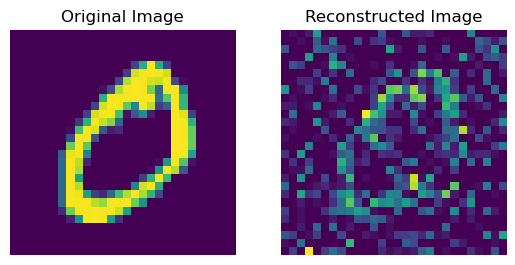

In [11]:
SNN.predict_sample(X_t[0])

In [26]:
SNN.train(X_t, X_v, epochs_num=1)

100%|███████████████████████████████████████████████████████████████████████████████| 10862/10862 [3:39:56<00:00,  1.21s/it]

Training reconstruction MSE on epoch 0: 45.54604230442186
Validation reconstruction MSE on epoch 0: 44.714706108921234


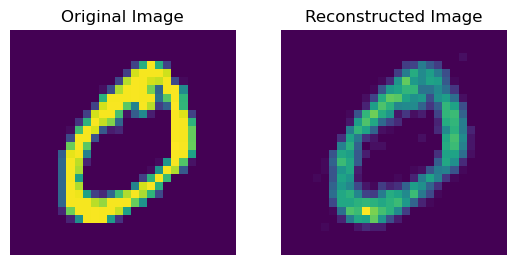

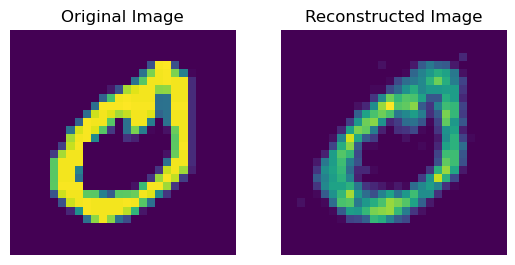

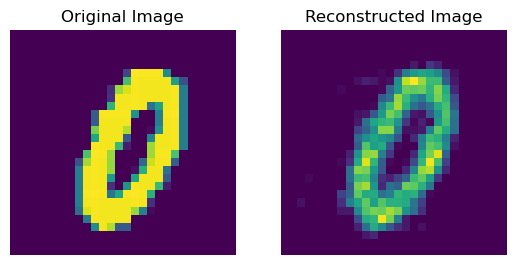

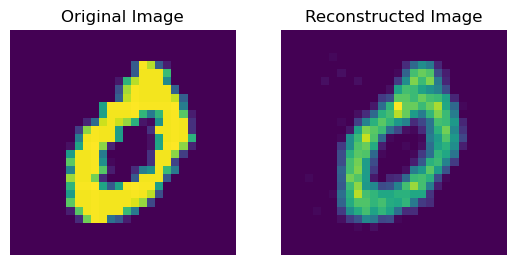

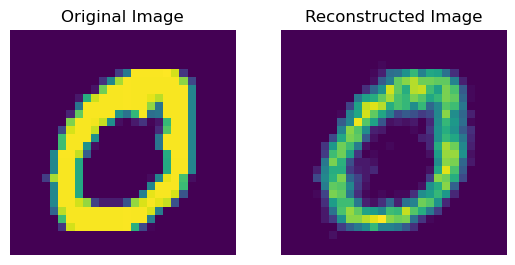

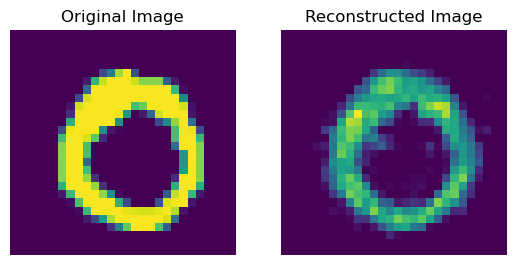

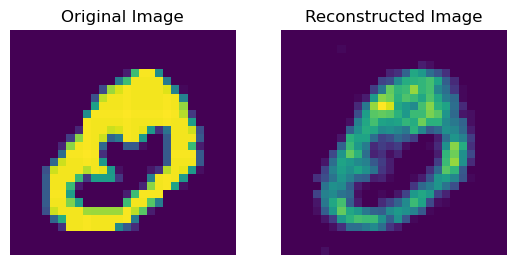

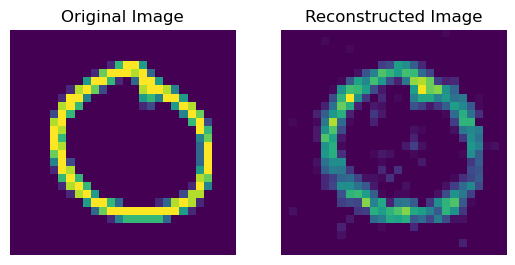

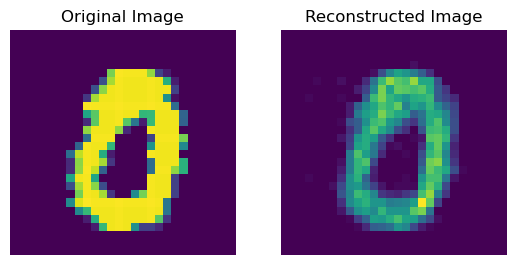

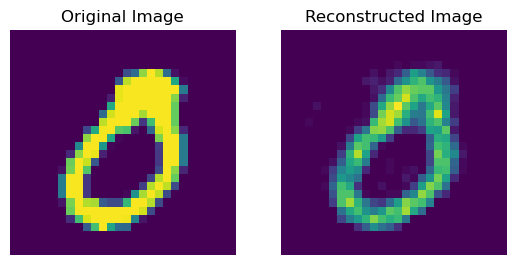

In [13]:
for i in range(1):
    SNN.predict_sample(X_test[10])

(array([6.6000e+01, 1.7060e+03, 3.5106e+04, 7.2616e+04, 7.2386e+04,
        4.7301e+04, 5.2680e+03, 6.8100e+02, 6.4000e+01, 6.0000e+00]),
 array([-6.62777916, -5.04887557, -3.46997198, -1.89106838, -0.31216479,
         1.2667388 ,  2.84564239,  4.42454598,  6.00344958,  7.58235317,
         9.16125676]),
 <BarContainer object of 10 artists>)

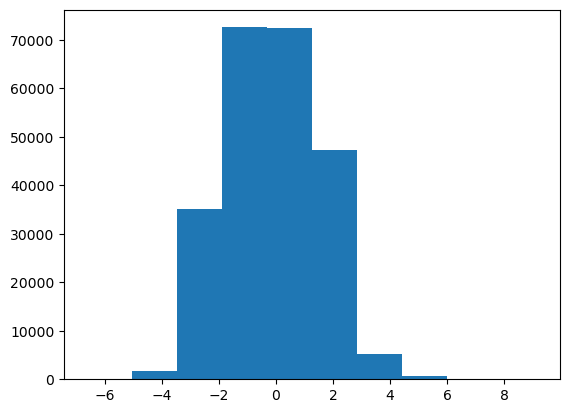

In [14]:
plt.hist(SNN.net['ho_synapses'].w)

(array([6.6000e+01, 1.7060e+03, 3.5106e+04, 7.2616e+04, 7.2386e+04,
        4.7301e+04, 5.2680e+03, 6.8100e+02, 6.4000e+01, 6.0000e+00]),
 array([-6.62777916, -5.04887557, -3.46997198, -1.89106838, -0.31216479,
         1.2667388 ,  2.84564239,  4.42454598,  6.00344958,  7.58235317,
         9.16125676]),
 <BarContainer object of 10 artists>)

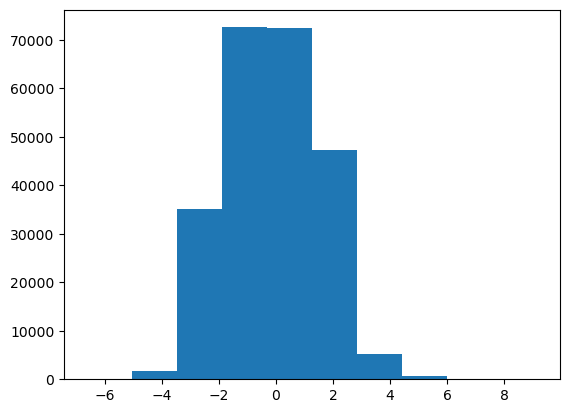

In [15]:
plt.hist(SNN.net['ih_synapses'].w)

In [16]:
def evaluate(model,X_test):
    error_test = 0
    coefs = []
    for x in tqdm(X_test):
        model._prepare_network(x)
        model.net.run(sim_duration*ms)
        original = (model.net['SM2'].count/(sim_duration/1000))
        reconstructed = (model.net['SM'].count/(sim_duration/1000))
        error = (reconstructed - original)
        error_test+=np.mean(np.power(error,2))
        pc = stats.pearsonr(original,reconstructed)
        coefs.append(pc)   
    print("Test MSE reconstruction error: " + str(error_test/len(X_test)))
    print("PC: ", np.mean(coefs))
    
    mse = error_test/len(X_test)
    mean_pc = np.mean(coefs)
    
    with open("results_mnist.csv","a") as f:
        f.write(f"{mse},{mean_pc}")

In [27]:
evaluate(SNN, X_test)

100%|███████████████████████████████████████████████████████████████████████████████| 10000/10000 [3:27:29<00:00,  1.24s/it]

Test MSE reconstruction error: 45.12483163265296
PC:  0.47163304487950225


In [18]:
SNN.net['ho_synapses'].w[0,1]

array([0.47500383])

In [19]:
SNN.net['ih_synapses'].w[1,0]

array([0.47500383])